<a href="https://colab.research.google.com/github/jinsungmin/2021_cau_oss_hackathon/blob/main/hackathon_team05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 해커톤 진행 주의사항**

**1)  개발 관련 주의사항**
*   [1. 초기 환경 설정]은 절대 수정하지 말 것
*   모든 구현은 [2. 데이터 전처리] 및 [3.모델 생성]에서만 진행
*   [4. 모델 저장]에서 team_name 변수 변경 (예.`team_name = 'team01'`)
 *    트레이닝 중간에 checkpoint를 활용하여 모델을 저장한 경우에도 파일 이름 양식 통일 필수
*   Colab 사용중 실수로 데이터 손실이 발생할 수도 있으니 중간 결과값을 github에 업로드 
 *    "런타임->모든 런타임 재설정"은 절대 누르지 말 것 (저장한 모델 데이터가 모두 삭제됨)
*   효율적인 구현 및 테스팅을 위해 GPU 가속 기능 활성화
 *    "런타임 -> 런타임 유형변경 -> 하드웨어 가속기 -> GPU 설정"
*   주석을 최대한 자세히 작성
*   Keras API 관련하여 [Keras Documentation](https://keras.io/) 참조

**2) 제출 관련 주의사항**
*  제출물
 *  소스코드 (hackathon_teamXX.ipynb)
 *  컴파일된 모델 파일 (model_entire_teamXX.h5)
 *  모델 발표 자료 
* 제출 기한: **오후 6시 (단, 발표자료는 12시)**
* 제출 방법: [GitHub README](https://github.com/cauosshackathonta/2021_cau_oss_hackathon/) 참조

 
**3) 평가 관련 주의사항**
*  모델 성능 = 두개의 테스트 데이터 셋 분류 정확도에 대한 weighted sum
 *  model.evaluate(x_test1, y_test1) + model.evaluate(x_test2, y_test2) * 2
*  제출된 모델들의 테스트 데이터 셋 분류 정확도를 기준으로 수상작 결정
*  수상 후보들에 대해서는 소스코드를 기반으로 모델 재검증 
 
**4) 수상 실격 사유**
*  유사한 소스코드 or 알고리즘이 적발될 경우
*  소스코드와 제출된 모델이 상이한 경우
*  개발 관련 주의사항을 지키지 않은 경우
 *  예: [초기 환경 설정]을 수정한 경우
*  데이터 셋을 변조한 경우
 *  예: 테스트 데이터 셋을 트레이닝 데이터 셋에 포함하여 모델 생성
 *  단, tensorflow.data 및 dataset API를 사용하기 위해 변경하는 것은 허용. 이 경우, model evaluation 파트도 해당 API를 쓰도록 변경  
*  주석이 소스코드와 맞지 않거나 미비할 경우






# **1. 초기 환경 설정**



In [22]:
# tensorflow와 tf.keras 및 관련 라이브러리 임포트
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.utils import np_utils

# 데이터셋 로드 (Training dataset: CIFAR10, test dataset: CIFAR10 & CIFAR10의 변형)
(x_train, y_train), (x_test1, y_test1) = keras.datasets.cifar10.load_data()

test_ds2 = tfds.load('cifar10_1/v6', split='test', shuffle_files=False, batch_size=-1)
test_ds2 = tfds.as_numpy(test_ds2)
x_test2, y_test2 = test_ds2['image'], test_ds2['label']

#분류를 위해 클래스 벡터를 바이너리 매트릭스로 변환
y_train = np_utils.to_categorical(y_train)
y_test1 = np_utils.to_categorical(y_test1)
y_test2 = np_utils.to_categorical(y_test2)

# 총 클래스 개수
num_classes = y_train.shape[1]
input_shape = x_train.shape[1:]

# **2. 데이터 전처리**



In [23]:
IMG_SIZE = 256
resize_and_rescale = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  keras.layers.experimental.preprocessing.Rescaling(1./255)                          
])

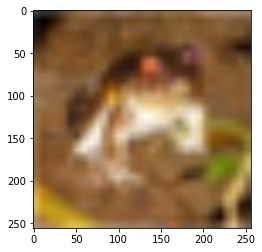

In [24]:
result = resize_and_rescale(x_train[0])
plt.imshow(result)
plt.show()

In [25]:

data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
  keras.layers.experimental.preprocessing.RandomZoom(0.5, width_factor=None, fill_mode='reflect',
    interpolation='bilinear', seed=None, fill_value=0.0,),
])

In [26]:
print(x_train[0].shape)
aaa = tf.expand_dims(x_train[0],0)
print(aaa.shape)

(32, 32, 3)
(1, 32, 32, 3)


In [ ]:
import copy
import matplotlib.pyplot as plt
import cv2
import numpy as np
x_train_after = copy.deepcopy(x_train)

# aug image add
for i in range(50000):
    if i % 1000 == 0:
      print(i)
      
    now_tmp = data_augmentation(tf.expand_dims(x_train[i],0))
    x_train_after = np.vstack((x_train_after, now_tmp))

print(x_train_after.shape)

0


In [ ]:
for i in range(50000):
    now_tmp = tf.image.rgb_to_grayscale(x_train[i])
    now_tmp = tf.image.grayscale_to_rgb(now_tmp)
    now_tmp = tf.expand_dims(now_tmp,0)
    x_train_after = np.vstack((x_train_after, now_tmp))

print(x_train_after.shape)

(50150, 32, 32, 3)


In [ ]:
# 데이터 전처리 (예: normalization)
# 원본 데이터와 전처리 후 데이터를 구분하기 위해, 변수명 x_train_after, x_test1_after, x_test2_after를 변경하지 말 것
x_train_after = x_train / 255.0
x_test1_after = x_test1 / 255.0
x_test2_after = x_test2 / 255.0

y_train = np.vstack((y_train,y_train))
print(y_train.shape)

# **3. 모델 생성**

In [ ]:
model = keras.Sequential()

# Feature 
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='valid', input_shape=input_shape, activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(128, kernel_size=(3,3),padding='valid', activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(256, kernel_size=(3,3), activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

# 3차원 tensor를 1차원 vector로 변환
model.add(keras.layers.Flatten(input_shape=input_shape))

# Classifier
model.add(keras.layers.Dense(256, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.25))

# 출력층
model.add(keras.layers.Dense(num_classes, activation=tf.nn.softmax))



# 모델 컴파일
# optimizer: 모델을 업데이트 하는 방식
# loss: 모델의 정확도를 판단하는 방식
# metrics: 트레이닝 및 테스팅 성능 모니터링을 위한 평가지표
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# 체크포인트 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoint_entire_best.h5', monitor='val_accuracy', verbose=1, save_weight_only=False, save_best_only=True, mode='auto')

# 모델 트레이닝
# batch_size: 전체 데이터셋 중 몇개씩 학습시킬 것인지
# epoch: 학습에 전체 데이터셋이 총 몇번 이용될 것인지
# shuffle: 학습전에 트레이닝 데이터셋을 랜덤하게 섞을 것인지
# validation_data: 중간 성능 검증에 사용할 data set (x_test1_after, x_test2_after, 혹은 둘을 merge해서 사용)
model.fit(x_train_after, y_train, batch_size = 128, epochs = 1, shuffle=True, callbacks=[cp_callback], validation_data=(x_test2_after, y_test2))

391/391 [==============================] - 187s 476ms/step - loss: 1.6434 - accuracy: 0.3912 - val_loss: 1.5956 - val_accuracy: 0.4215

Epoch 00001: val_accuracy improved from -inf to 0.42150, saving model to /content/checkpoint_entire_best.h5


# **4. 모델 저장**

In [ ]:
save_path = '/content/'
team_name = 'team15'

# 트레이닝된 전체 모델을 저장합니다.
model.save(save_path +  'model_entire_'+ team_name + '.h5')

# **5. 모델 로드 및 평가**

In [ ]:
save_path = '/content/'
team_name = 'team15'

model = keras.models.load_model(save_path + 'model_entire_' + team_name + '.h5')

model.evaluate(x_test1_after, y_test1)
model.evaluate(x_test2_after, y_test2)

63/63 [==============================] - 2s 29ms/step - loss: 1.5956 - accuracy: 0.4215


[1.5956077575683594, 0.42149999737739563]